# Implementation of dynamic circuit for Quantum Phase Estimation using TheQ

This notebook will teach you how to construct your own dynamic circuits for Quantum Phase Estimation using TheQ.

# Importing Packages

In [ ]:
# Server addresses should be stable, but may occasionally be offline
import requests
import json
import math
from google.colab import files
req_str = 'http://8fc11588c850.ngrok.io/qsim/perform_operation'
req_str_qasm = 'http://8fc11588c850.ngrok.io/qsim/qasm'
import numpy as np # To play around with pi
import matplotlib.pyplot as plt # For plotting Histograms

# Required functions

These are some required functions to run any circuit in TheQ.

In [ ]:
# Define Create ciruit (these are the four core definitions for any circuit)
# all circuits must be bookmarked by the create_circuit and destroy_circuit command

# Initial_state is a binary integer to initalise all qubit, 
# most often initial_state=0.
def create_circuit(qubits,initial_state):
    data = {
        'operation': 'create_circuit',
        'num_qubits': qubits
    }
    result = requests.post(req_str, json=data)
    json_obj = json.loads(result.content)
    reg_id = json_obj['result']

    data = {
        'operation': 'set_state',
        'register': reg_id,
        'state': initial_state,
        'complex_value': {'re': 1, 'im': 0}
    }
    result = requests.post(req_str, json=data)
    return reg_id

# Gates.  gate_name and params are specified from the list above
def gate(register_id, gate_name, params):
    data = {
        'operation': 'gate',
        'register': register_id,
        'gate': gate_name
    }
    for k in params.keys():
        data[k] = params[k]
    result = requests.post(req_str, json=data)
    json_obj=json.loads(result.content)
    return json_obj['result']

# params contain an array of qubit numbers to measure, 'lq2m': [0,1,3] would measure qubits 0, 1 and 3 and return the 
# corresponding 3-bit integer value from 0 to 7.
def measure_qubit(register_id, params):
    data = {
        'operation': 'measure', 
        'register': register_id,
    }
    for k in params.keys():
        data[k] = params[k]
    result = requests.post(req_str, json=data)

    json_obj = json.loads(result.content)
    return json_obj['result']

# Always call destroy_circuit to terminate simulation (turn off your QC)
def destroy_circuit(register_id):
  data = {
        'operation': 'destroy_circuit', 
        'register': register_id
  }
  result = requests.post(req_str, json=data)

# Print allows you to output the current computational state of the machine.
def print_vector(register_id):
  data = {
        'operation': 'state_vector', 
        'register': register_id
  }
  result = requests.post(req_str, json=data)
  json_obj = json.loads(result.content)
  return json_obj['result']

# The circuits

Now, we move on to main part of the notebook. In this section, we shall explain the construction of dynamic circuits for Quantum Phase Estimation of a single qubit gate, with $3$-bit precision expected. Given a method to prepare an eigenvector $| \psi \rangle$ of a one-qubit gate $U$, the circuit should be able to compute the phase of it's corresponding eigenvalue, that is, $\theta$ such that $e^{2\pi i \theta}$ is the eigenvalue associated with $| \psi \rangle$. For a $3$-bit approximation of $\theta$, the usual circuit for Quantum Phase Estimation requires $2 ^ {0} + 2 ^ {1} + 2 ^ {2} = 7$ controlled-$U$ gates and an inverse Quantum Fourier Transform circuit. The circuit is as follows:

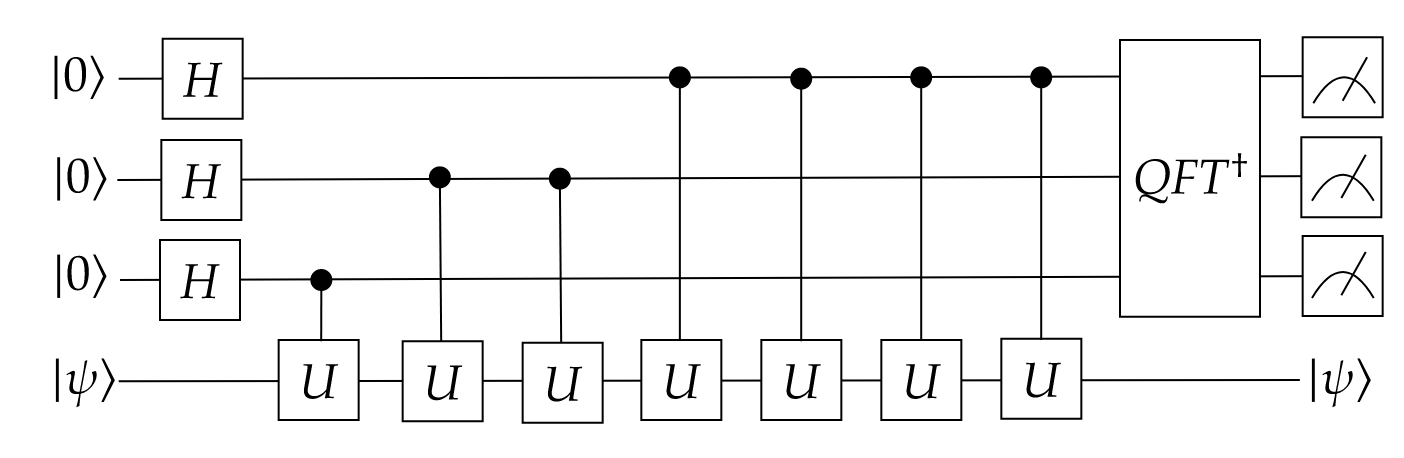

The idea of a dynamic Quantum Phase Estimation is to execute the same algorithm, but with $1$ qubit in the first register, whatever the required precision is. This is achieved by replacing the controlled operation in the inverse Quantum Fourier Transform circuit, with classical controlled quantum operations, that is, you measure the qubit and based on the result, decide to apply the quantum gate or not. The Quantum Phase Estimation circuit given above can be dynamically executed by the circuits given below

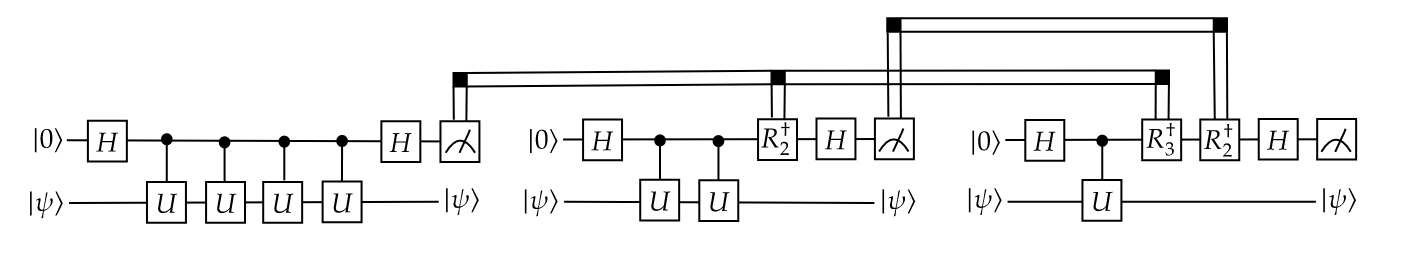

# Case 1

In this example, we are going to take $U$ to be the matrix

\begin{equation}
  U = 
  \begin{bmatrix}
    1 & 0 \\
    0 & e^{\frac{\pi i}{4}}
  \end{bmatrix}
\end{equation}

This is the famed $T$ gate. Since this is a diagonal matrix, it's eigenvectors are $|0\rangle$ with eigenvalue $1$ and $|1\rangle$ with eigenvalue $e^{\frac{ \pi i}{4}}$. That means, the phase associated with the eigenvector $|1\rangle$ is $\frac{1}{8}$, and the phase associated with the eigenvector $|0\rangle$ is $0$. 

For $R_k$ gates, we can use the rotation around $Z$-axis gate given as 
\begin{equation}
  R_Z(\phi) = 
  \begin{bmatrix}
    e ^ {\frac{-i\phi}{2}} & 0\\
    0 & e ^ {\frac{i\phi}{2}}
  \end{bmatrix}
\end{equation}

If we want to carry out phase estimation with this matrix, then we should be able to apply this matrix, as a gate, in a controlled manner, that is, we should be able to use the gate

\begin{equation}
  CU =
  \begin{bmatrix}
    1 & 0 & 0 & 0\\
    0 & 1 & 0 & 0\\
    0 & 0 & 1 & 0\\
    0 & 0 & 0 & e ^ {\frac{\pi i}{4}}
  \end{bmatrix}
\end{equation}
 
 This can be achieved by the controlled phase gate in TheQ, whose form is 

 \begin{equation}
  CPHASE(\phi) =
  \begin{bmatrix}
    1 & 0 & 0 & 0\\
    0 & 1 & 0 & 0\\
    0 & 0 & 1 & 0\\
    0 & 0 & 0 & e ^ {i \phi}
  \end{bmatrix}
\end{equation}


## When $| \psi \rangle = |1\rangle$

In this section, we shall use our $U$ gate to compute the phase associated with it's eigenvector $|1\rangle$, dynamically. The circuit then will have the form

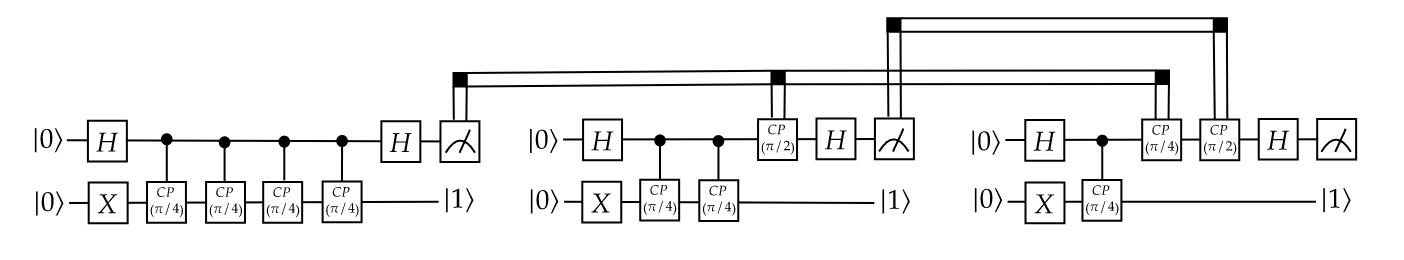

Now, let's move on to constructing the circuit using TheQ. In our construction, the bottom qubit in the circuit diagram given above is qubit 0 and the top qubit is qubit 1.

From the cirucit diagram, we can see that we have to execute $3$ circuits, each one based on the output of the previous one. So, we shall use a list to keep track of the measurment results.

In [ ]:
measurement_results = []

Now we shall move on to contructing the first circuit. First, we prepare the quantum circuit with $2$ qubits.

In [ ]:
# Prepare the circuit
reg_id = create_circuit(2,0)

Now, we shall start applying the gates.

The first step to to prepare the eigenvector $|1\rangle$ in the qubit 0. 

In [ ]:
# Apply X gate on qubit 0 to prepare the eigenvector
gate(reg_id, 'X', {'q': 0})

True

Next step is to apply Hadamard gates on other qubit.

In [ ]:
# Apply Hadamard gate on qubit 1
gate(reg_id, 'hadamard', {'q': 1})

True

Now, we shall apply the controlled rotations.

In [ ]:
# Apply controlled rotations controlled on qubit 1
for count in range(4):
  gate(reg_id, 'cphase', {'q_control': 1, 'q_target': 0, 'theta': np.pi/4})

Now let's apply the final Hadamard gate and measure.

In [ ]:
# Apply Hadamard gates on qubits 1
gate(reg_id, 'hadamard', {'q': 1})

# Measure
c0 = measure_qubit(reg_id,{'lq2m': [1]})

# Destroy circuit
destroy_circuit(reg_id)
measurement_results.append(c0)

# Display circuit
print(c0)

1


The output is $1$. Based this, we shall build the second circuit. 

Since the first circuit resulted in $1$, the second circuit should have the $R_2$ gate. 

In [ ]:
# Prepare the circuit
reg_id = create_circuit(2,0)

# Apply X gate on qubit 0 to prepare the eigenvector
gate(reg_id, 'X', {'q': 0})

# Apply Hadamard gate on qubit 1
gate(reg_id, 'hadamard', {'q': 1})

# Apply controlled rotations controlled on qubit 1
for count in range(2):
  gate(reg_id, 'cphase', {'q_control': 1, 'q_target': 0, 'theta': np.pi/4})

gate(reg_id, 'zrot', {'q': 1, 'theta': np.pi/2})

# Apply Hadamard gates on qubits 1
gate(reg_id, 'hadamard', {'q': 1})

# Measure
c0 = measure_qubit(reg_id,{'lq2m': [1]})

# Destroy circuit
destroy_circuit(reg_id)
measurement_results.append(c0)

# Display circuit
print(c0)

0


We see that the output is $0$. Based on the $2$ outputs, we have seen so far, we build the third and final circuit. 

In [ ]:
# Prepare the circuit
reg_id = create_circuit(2,0)

# Apply X gate on qubit 0 to prepare the eigenvector
gate(reg_id, 'X', {'q': 0})

# Apply Hadamard gate on qubit 1
gate(reg_id, 'hadamard', {'q': 1})

# Apply controlled rotations controlled on qubit 1
gate(reg_id, 'cphase', {'q_control': 1, 'q_target': 0, 'theta': np.pi/4})

# Apply rotation based on the previous measurement outputs.
gate(reg_id, 'zrot', {'q': 1, 'theta': np.pi/2})

# Apply Hadamard gates on qubits 1
gate(reg_id, 'hadamard', {'q': 1})

# Measure
c0 = measure_qubit(reg_id,{'lq2m': [1]})

# Destroy circuit
destroy_circuit(reg_id)
measurement_results.append(c0)

# Display circuit
print(c0)

0


So, the final bitstring is

In [ ]:
measurement_results.reverse()
measurement_results

[0, 0, 1]

Now, let's carry out this circuit a $100$ times

In [ ]:
results = {}

In [ ]:
while sum([results[key] for key in results]) < 100:

  # Initialize the measurement result list
  measurement_results = []
  for control_qubit in range(3):

    # Prepare the circuit
    reg_id = create_circuit(2,0)

    # Apply X gate on qubit 0 to prepare the eigenvector
    gate(reg_id, 'X', {'q': 0})

    # Apply Hadamard gate on qubit 1
    gate(reg_id, 'hadamard', {'q': 1})

    # Apply controlled rotations controlled on qubit 1
    for count in range(2 ** (2-control_qubit)):
      gate(reg_id, 'cphase', {'q_control': 1, 'q_target': 0, 'theta': np.pi/4})

    for k in range(len(measurement_results)):
      if measurement_results[k] == 1:
        gate(reg_id, 'zrot', {'q': 1, 'theta': np.pi/(2 ** (len(measurement_results) - k))})

    # Apply Hadamard gates on qubits 1
    gate(reg_id, 'hadamard', {'q': 1})

    # Measure
    c0 = measure_qubit(reg_id,{'lq2m': [1]})

    measurement_results.append(c0)

    # Destroy circuit
    destroy_circuit(reg_id)
  measurement_results.reverse()
  
  # Update the results
  try:
    results[''.join([str(x) for x in measurement_results])] += 1

  except KeyError:
    results[''.join([str(x) for x in measurement_results])] = 1
  


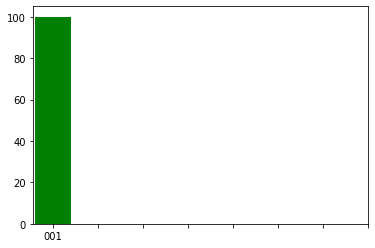

In [ ]:
# Plot the results
plt.bar(results.keys(), results.values(), color='g')
plt.xticks(list(range(8)))
plt.show()

As we can see, the output is always $1$. Now, to the get the value of the phase $\theta$, we simply divide the output by $2^{3} = 8$, which gives us $\frac{1}{8}$, which is the correct answer. 

## When $| \psi \rangle = |0\rangle$

In this section, we shall use our $U$ gate to compute the phase associated with it's eigenvector $|0\rangle$, dynamically Our final circuit will have the form

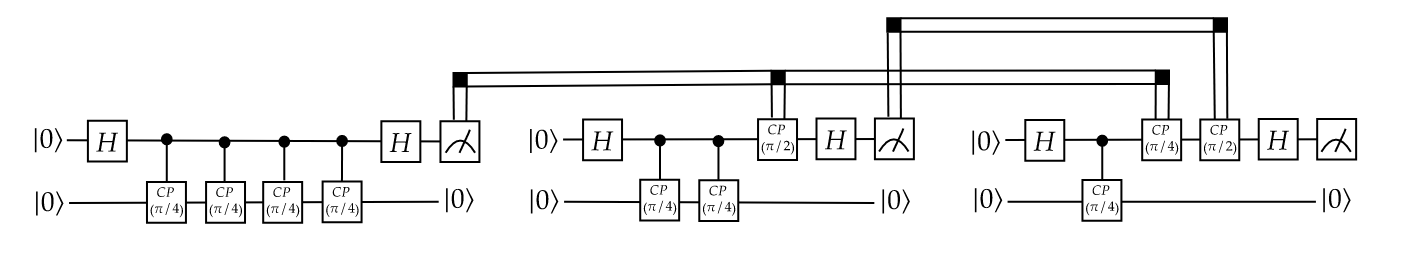

Since constructing and executing the phase estimation circuit for the eigenvector $|1\rangle$ was explained in detail in the previous section, we are not going to explain the circuit for the eigenvector $|0\rangle$'s extensively as it is extremely similar to that of $|1\rangle$, except for the vector preparation part. 

Executing the cell below runs a dynamic quantum circuit for the Quantum Phase Estimation for the unitary $U$ and the eigenvector $|0\rangle$ $100$ times.

In [ ]:
results = {}

In [ ]:
while sum([results[key] for key in results]) < 100:

  # Initialize the measurement result list
  measurement_results = []
  for control_qubit in range(3):

    # Prepare the circuit
    reg_id = create_circuit(2,0)

    # Apply Hadamard gate on qubit 1
    gate(reg_id, 'hadamard', {'q': 1})

    # Apply controlled rotations controlled on qubit 1
    for count in range(2 ** (2-control_qubit)):
      gate(reg_id, 'cphase', {'q_control': 1, 'q_target': 0, 'theta': np.pi/4})

    for k in range(len(measurement_results)):
      if measurement_results[k] == 1:
        gate(reg_id, 'zrot', {'q': 1, 'theta': np.pi/(2 ** (len(measurement_results) - k))})

    # Apply Hadamard gates on qubits 1
    gate(reg_id, 'hadamard', {'q': 1})

    # Measure
    c0 = measure_qubit(reg_id,{'lq2m': [1]})

    # Destroy circuit
    destroy_circuit(reg_id)
    measurement_results.append(c0)
    
  measurement_results.reverse()
  
  # Update the results
  try:
    results[''.join([str(x) for x in measurement_results])] += 1

  except KeyError:
    results[''.join([str(x) for x in measurement_results])] = 1



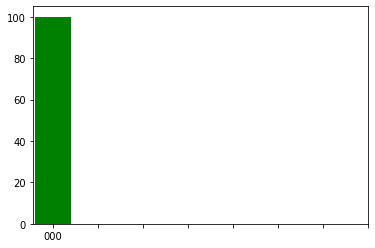

In [ ]:
# Plot the results
plt.bar(results.keys(), results.values(), color='g')
plt.xticks(list(range(8)))
plt.show()

As we can see, the output is always $0$, which means that the phase associated with $|0\rangle$ is $0$.

# Case 2

In case of the $T$ gate, since the phase is $\frac{1}{8}$ we always get the exact answer as the output of the phase estimation circuit, if we use $3$ qubits in th first register. We know that in most cases, the output of the phase estimation circuit is an approximation of the phase, rather than the exact answer. Consider the gate

\begin{equation}
  U = 
  \begin{bmatrix}
    1 & 0 \\
    0 & e^{\frac{2 \pi i}{5}}
  \end{bmatrix}
\end{equation}

Since this is also a diagonal matrix, it's eigenvectors are $|0\rangle$ with eigenvalue $1$ and $|1\rangle$ with eigenvalue $e^{\frac{ 2 \pi i}{5}}$. That means, the phase associated with the eigenvector $|1\rangle$ is $\frac{1}{5}$, and the phase associated with the eigenvector $|0\rangle$ is $0$. If we want to carry out phase estimation with this matrix, then we should be able to apply this matrix, as a gate, in a controlled manner, that is, we should be able to use the gate

\begin{equation}
  CU =
  \begin{bmatrix}
    1 & 0 & 0 & 0\\
    0 & 1 & 0 & 0\\
    0 & 0 & 1 & 0\\
    0 & 0 & 0 & e ^ {\frac{2 \pi i}{5}}
  \end{bmatrix}
\end{equation}
 
This, can be done by the controlled-phase gate available in TheQ, whose structure is described in the previous section. 


## When $| \psi \rangle = |0\rangle$

In this case, we start with finding the phase associated with the eigenvector $|0\rangle$. The final circuit will have the form

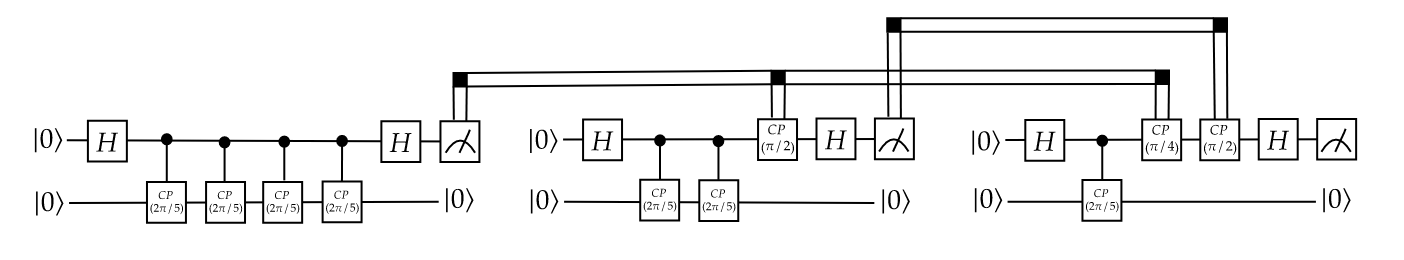

Executing the cell below runs a dynamic quantum circuit for the Quantum Phase Estimation for the unitary $U$ and the eigenvector $|0\rangle$ $100$ times.

In [ ]:
results = {}

In [ ]:
while sum([results[key] for key in results]) < 100:

  # Initialize the measurement result list
  measurement_results = []
  for control_qubit in range(3):

    # Prepare the circuit
    reg_id = create_circuit(2,0)

    # Apply Hadamard gate on qubit 1
    gate(reg_id, 'hadamard', {'q': 1})

    # Apply controlled rotations controlled on qubit 1
    for count in range(2 ** (2-control_qubit)):
      gate(reg_id, 'cphase', {'q_control': 1, 'q_target': 0, 'theta': 2 * np.pi/5})

    for k in range(len(measurement_results)):
      if measurement_results[k] == 1:
        gate(reg_id, 'zrot', {'q': 1, 'theta': np.pi/(2 ** (len(measurement_results) - k))})

    # Apply Hadamard gates on qubits 1
    gate(reg_id, 'hadamard', {'q': 1})

    # Measure
    c0 = measure_qubit(reg_id,{'lq2m': [1]})

    # Destroy circuit
    destroy_circuit(reg_id)
    measurement_results.append(c0)

  measurement_results.reverse()
  
  # Update the results
  try:
    results[''.join([str(x) for x in measurement_results])] += 1

  except KeyError:
    results[''.join([str(x) for x in measurement_results])] = 1


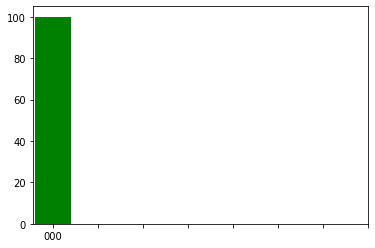

In [ ]:
# Plot the results
plt.bar(results.keys(), results.values(), color='g')
plt.xticks(list(range(8)))
plt.show()

As we can see, the output is always $0$, which means that the phase associated with $|0\rangle$ is $0$.


## When $| \psi \rangle = |1\rangle$

Now, we shall move on to finding the phase associated with the eigenvector $|1\rangle$. The circuit will then have the form

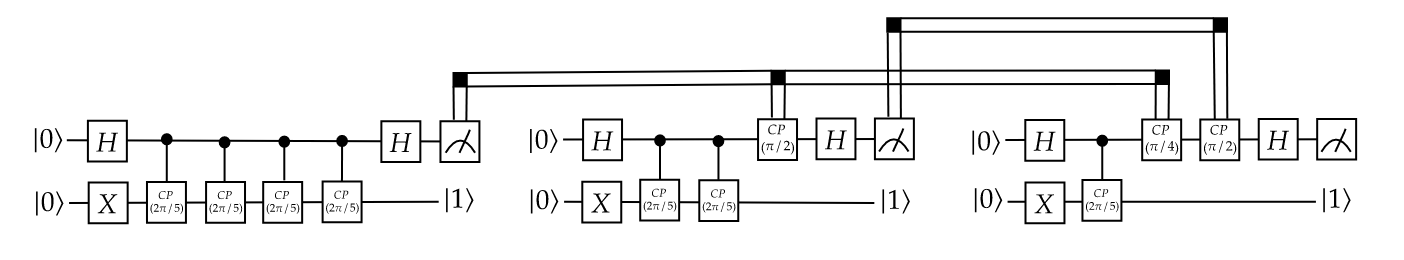

Executing the cell below runs a dynamic quantum circuit for the Quantum Phase Estimation for the unitary $U$ and the eigenvector $|1\rangle$ $100$ times.

In [ ]:
results = {}

In [ ]:
while sum([results[key] for key in results]) < 100:

  # Initialize the measurement result list
  measurement_results = []
  for control_qubit in range(3):

    # Prepare the circuit
    reg_id = create_circuit(2,0)

    # Apply Hadamard gate on qubit 1
    gate(reg_id, 'hadamard', {'q': 1})

    # Apply X gate on qubit 0 to prepare the eigenvector
    gate(reg_id, 'X', {'q': 0})

    # Apply controlled rotations controlled on qubit 1
    for count in range(2 ** (2-control_qubit)):
      gate(reg_id, 'cphase', {'q_control': 1, 'q_target': 0, 'theta': 2 * np.pi/5})

    for k in range(len(measurement_results)):
      if measurement_results[k] == 1:
        gate(reg_id, 'zrot', {'q': 1, 'theta': np.pi/(2 ** (len(measurement_results) - k))})

    # Apply Hadamard gates on qubits 1
    gate(reg_id, 'hadamard', {'q': 1})

    # Measure
    c0 = measure_qubit(reg_id,{'lq2m': [1]})

    # Destroy circuit
    destroy_circuit(reg_id)
    measurement_results.append(c0)

  measurement_results.reverse()
  
  # Update the results
  try:
    results[''.join([str(x) for x in measurement_results])] += 1

  except KeyError:
    results[''.join([str(x) for x in measurement_results])] = 1



100


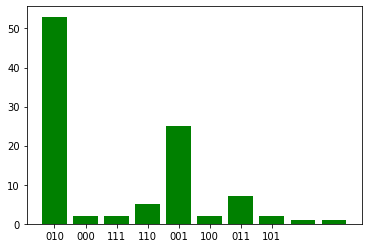

In [ ]:
# Plot the results
plt.bar(results.keys(), results.values(), color='g')
plt.xticks(list(range(8)))
plt.show()

In this case, we see that there have been multiple outcomes as the result of this simulation. The most probable outcome is $2$. That means, the phase associated with $|1\rangle$ is approximately $\frac{2}{2^3} = \frac{1}{4}$. The exact value of the phase is $\frac{1}{5}$. So, the approximation returned by the circuit makes sense.